# Exploratory Data Analysis (EDA) for Movie Ratings Dataset

### 1. Load and Inspect Data

In [3]:
import os
import sys
# Set the working directory to the project root
os.chdir("/Users/isaacgonzales/Desktop/Sample")
sys.path.append(os.path.abspath("src"))
from src.data_fetching import load_imdb_data  
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
title_basics = load_imdb_data("title_basics")
title_ratings = load_imdb_data("title_ratings")

In [ ]:
# Validate if the "load_imdb_data" function properly casts the data type
display(title_basics.info())
display(title_ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11516411 entries, 0 to 11516410
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tconst          string 
 1   titleType       string 
 2   primaryTitle    string 
 3   originalTitle   string 
 4   isAdult         boolean
 5   startYear       Int64  
 6   endYear         Int64  
 7   runtimeMinutes  Int64  
 8   genres          string 
dtypes: Int64(3), boolean(1), string(5)
memory usage: 757.8 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544438 entries, 0 to 1544437
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1544438 non-null  string 
 1   averageRating  1544438 non-null  float64
 2   numVotes       1544438 non-null  Int64  
dtypes: Int64(1), float64(1), string(1)
memory usage: 36.8 MB


None

In [6]:
# Inspect the number of empty rows per column on each tables
print(title_basics.isnull().sum())
print(title_ratings.isnull().sum())

tconst                   0
titleType                0
primaryTitle            19
originalTitle           19
isAdult                824
startYear          1425406
endYear           11379071
runtimeMinutes     7854274
genres              508127
dtype: int64
tconst           0
averageRating    0
numVotes         0
dtype: int64


### 2. Create the main table named "titles"

In [7]:
# Merge "title_basics" table and "title ratings" table using the "tconst" column
titles = pd.merge(title_basics, title_ratings, on='tconst', how='inner')

In [8]:
# Validate the merged table named "titles"
display(titles.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544430 entries, 0 to 1544429
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   tconst          1544430 non-null  string 
 1   titleType       1544430 non-null  string 
 2   primaryTitle    1544429 non-null  string 
 3   originalTitle   1544429 non-null  string 
 4   isAdult         1544427 non-null  boolean
 5   startYear       1544178 non-null  Int64  
 6   endYear         60855 non-null    Int64  
 7   runtimeMinutes  1080668 non-null  Int64  
 8   genres          1522456 non-null  string 
 9   averageRating   1544430 non-null  float64
 10  numVotes        1544430 non-null  Int64  
dtypes: Int64(4), boolean(1), float64(1), string(5)
memory usage: 126.7 MB


None

### 3.  Handle missing values 

In [9]:
# Check for missing values of the merged table
print(titles.isnull().sum())

tconst                  0
titleType               0
primaryTitle            1
originalTitle           1
isAdult                 3
startYear             252
endYear           1483575
runtimeMinutes     463762
genres              21974
averageRating           0
numVotes                0
dtype: int64


In [10]:
# Drop rows with missing primary title, original title and start year
titles.dropna(subset=['primaryTitle', 'originalTitle','startYear'], inplace=True)  

In [11]:
# Validate the removed rows with missing value
print(titles.isnull().sum())

tconst                  0
titleType               0
primaryTitle            0
originalTitle           0
isAdult                 0
startYear               0
endYear           1483322
runtimeMinutes     463604
genres              21969
averageRating           0
numVotes                0
dtype: int64


### 4. Explore the distributions and statistics

In [12]:
# Check unique values of "titles" table
print(titles.nunique())

tconst            1544177
titleType              10
primaryTitle      1141633
originalTitle     1159516
isAdult                 2
startYear             145
endYear                84
runtimeMinutes        705
genres               2081
averageRating          91
numVotes            23148
dtype: int64


In [13]:
# Check distrbution of title types of the "titles" table
print(titles['titleType'].value_counts())

titleType
tvEpisode       782540
movie           326638
short           168446
tvSeries        102700
video            55885
tvMovie          54935
tvMiniSeries     19720
videoGame        17847
tvSpecial        13051
tvShort           2415
Name: count, dtype: Int64


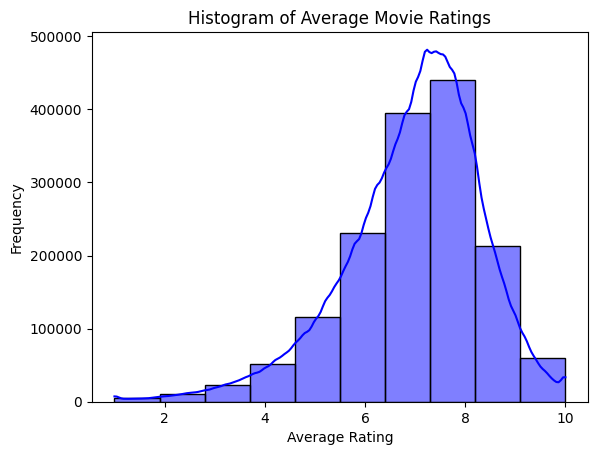

In [14]:
# Frequency distribution of the "averageRating" column
sns.histplot(titles["averageRating"], bins=10, kde=True, color="blue")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Average Movie Ratings")
plt.show()

In [15]:
# Summary statistics of "titles" table
columns_to_describe = ["runtimeMinutes","averageRating", "numVotes"] 
pd.set_option('display.float_format', '{:.2f}'.format)
display(titles[columns_to_describe].describe())

,runtimeMinutes,averageRating,numVotes
count,1080573.00,1544177.00,1544177.00
mean,58.63,6.95,1025.18
std,3553.31,1.39,17816.89
min,0.00,1.00,5.00
25%,23.00,6.20,11.00
50%,45.00,7.10,26.00
75%,85.00,7.90,100.00
max,3692080.00,10.00,3017073.00


### 5. Create a weighted average field and filter data for 2020 Movies

### Bayesian Weighted Average (BWA)

The Bayesian weighted rating is calculated using the formula:

$$
WR = \frac{v}{v + m} R + \frac{m}{v + m} C
$$

where:
- \( WR \) = Weighted Rating  
- \( R \) = Movie's average rating  
- \( v \) = Number of votes for the movie  
- \( m \) = Minimum votes required (threshold)  
- \( C \) = Global mean rating (average rating across all movies)  

This formula ensures that movies with very few votes do not dominate the rankings by balancing individual ratings with the overall dataset.


In [16]:
# Declare the minimum number of votes required to be considered high rating (m)
m = 1025 # Mean number of votes is used

# Compute the global mean of average ratings (C) 
C = titles["averageRating"].mean()

# Compute the Weighted Rating (WR) 
titles.loc[:, "weightedRating"] = (titles["numVotes"] / (titles["numVotes"] + m) * titles["averageRating"]) + \
                                   (m / (titles["numVotes"] + m) * C)

# Filter the Movie type titles in year 2020
movies = titles[(titles["startYear"] == 2020) & (titles["titleType"].isin(["movie", "tvMovie"]))]

# Display the results
display(movies)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,weightedRating
42369,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,False,2020,<NA>,70,Drama,6.40,229,6.85
69293,tt0093119,movie,Grizzly II: Revenge,Grizzly II: The Predator,False,2020,<NA>,74,"Horror,Music,Thriller",2.70,1826,4.23
247737,tt0438755,movie,About Face: The Story of the Jewish Refugee So...,About Face: The Story of the Jewish Refugee So...,False,2020,<NA>,94,Documentary,8.10,46,7.00
251174,tt0446792,movie,Surviving in L.A.,Surviving in L.A.,False,2020,<NA>,<NA>,"Comedy,Drama,Romance",7.40,32,6.97
408066,tt0805647,movie,The Witches,The Witches,False,2020,<NA>,106,"Adventure,Comedy,Family",5.40,48613,5.43
...,...,...,...,...,...,...,...,...,...,...,...,...
1544166,tt9912890,tvMovie,Ivy & Mistletoe,Ivy & Mistletoe,False,2020,<NA>,<NA>,"Family,Romance",4.90,230,6.58
1544313,tt9914192,movie,No Gogó do Paulinho,No Gogó do Paulinho,False,2020,<NA>,98,Comedy,5.30,318,6.56
1544388,tt9916190,movie,Safeguard,Safeguard,False,2020,<NA>,95,"Action,Adventure,Thriller",3.60,262,6.27
1544395,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,False,2020,<NA>,84,Thriller,5.80,1503,6.27


### 7. Insights and conclusion

In [17]:
# Print the top 10 movie titles based on weighted average rating
display(movies.sort_values(by="weightedRating", ascending=False).head(10))

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,weightedRating
586928,tt11989890,tvMovie,David Attenborough: A Life on Our Planet,David Attenborough: A Life on Our Planet,False,2020,<NA>,83,"Biography,Documentary",8.90,35282,8.85
479742,tt10189514,movie,Soorarai Pottru,Soorarai Pottru,False,2020,<NA>,153,Drama,8.70,127207,8.69
741335,tt14888874,movie,Demon Slayer: Kimetsu no Yaiba - Mt. Natagumo Arc,Kimetsu no Yaiba: Natagumo Yama-hen,False,2020,<NA>,138,"Action,Animation,Fantasy",8.70,17206,8.60
572645,tt11737772,movie,Chal Mera Putt 2,Chal Mera Putt 2,False,2020,<NA>,124,Drama,8.80,3509,8.38
1469411,tt8110330,movie,Dil Bechara,Dil Bechara,False,2020,<NA>,101,"Comedy,Drama,Romance",8.30,136015,8.29
1487309,tt8503618,movie,Hamilton,Hamilton,False,2020,<NA>,160,"Biography,Drama,History",8.30,125581,8.29
609485,tt12415546,movie,Attack on Titan: Chronicle,Shingeki no Kyojin: Chronicle,False,2020,<NA>,122,"Action,Adventure,Animation",8.40,12282,8.29
484828,tt10272386,movie,The Father,The Father,False,2020,<NA>,97,"Drama,Mystery",8.20,209721,8.19
1493227,tt8652818,movie,Violet Evergarden: The Movie,Gekijôban Vaioretto Evâgâden,False,2020,<NA>,140,"Animation,Drama,Fantasy",8.30,11881,8.19
531216,tt11032374,movie,Demon Slayer: Kimetsu no Yaiba - The Movie: Mu...,Gekijô-ban Kimetsu no Yaiba Mugen Ressha-hen,False,2020,<NA>,117,"Action,Adventure,Animation",8.20,82120,8.18


In [18]:
# Understand the distribution of ratings and votes of top 10 titles
movies_10 = movies.sort_values(by="weightedRating", ascending=False).head(10)
movies_10[["averageRating", "numVotes", "weightedRating"]].describe()


,averageRating,numVotes,weightedRating
count,10.00,10.00,10.00
mean,8.48,76080.40,8.40
std,0.27,70821.99,0.23
min,8.20,3509.00,8.18
25%,8.30,13513.00,8.22
50%,8.35,58701.00,8.29
75%,8.70,126800.50,8.55
max,8.90,209721.00,8.85


In [19]:
# Step 1: Split and explode the genres column
genre_counts = movies_10["genres"].str.split(",").explode().value_counts()

# Step 2: Convert to a DataFrame (optional)
genre_counts = genre_counts.reset_index()
genre_counts.columns = ["Genre", "Count"]

# Display the result
display(genre_counts)


,Genre,Count
0,Drama,6
1,Animation,4
2,Action,3
3,Biography,2
4,Fantasy,2
5,Adventure,2
6,Documentary,1
7,Comedy,1
8,Romance,1
9,History,1


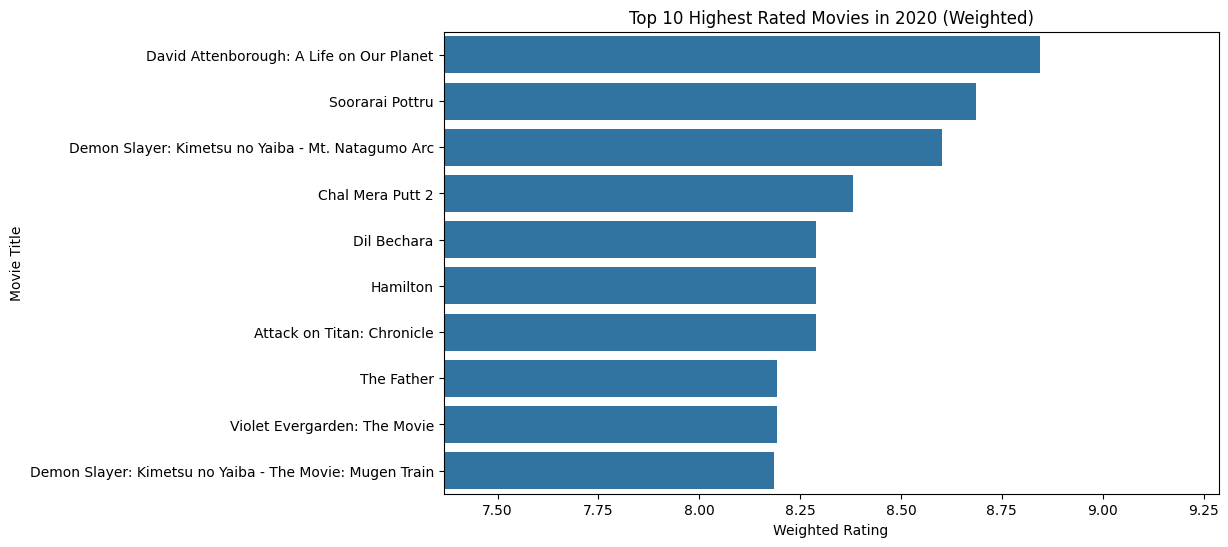

In [20]:
# Visualize the top 10 titles
plt.figure(figsize=(10, 6))
sns.barplot(
    x=movies_10["weightedRating"], 
    y=movies_10["primaryTitle"], 
)

plt.xlabel("Weighted Rating")
plt.ylabel("Movie Title")
plt.title("Top 10 Highest Rated Movies in 2020 (Weighted)")
plt.xlim(movies_10["weightedRating"].min() * 0.9, movies_10["weightedRating"].max() * 1.05)  # Adjust x-axis limits
plt.show()
